# Generation mechanistic hypotheses from TF-regulons linked to single cell -omics data

## One line summary of the chapter**

Describing a general example on how to generate a Gene Regulatory Network, using general bioinformatics tools.

## **Here, plus steps of the chapter**

In this chapter, we will explore scRNA-seq data and predicted TF-regulons through SCENIC. Specifically, we will execute SCENIC on a donor of the  NeurIPS 2021 dataset, and we will interpreting the results from SCENIC.

## **Outocome of the analysis. What things can be done with these outputs.**

Interpreting single cell RNA-seq data based on potential transcription factors regulating cell states and/or transitions.

## Regulons

### **Definition of a TF-regulon**

A regulon is a set of target genes that **regu**lated by a particular factor. In the context of gene regulation, a TF-regulon is a set of genes that is regulated by the activity of a transcription factor (TF).

### How we can get a regulon

TF- Regulons have been annotated in academic studies, databases that compiled those, and also consortia efforts such as ENCODE. Among general references, one can inspect [TTRUST](https://www.grnpedia.org/trrust/), [DoRothEA](https://saezlab.github.io/dorothea/), [KnockTF](http://www.licpathway.net/KnockTFv2/index.php), among others, for eukaryotic TF-regulons. For prokaryotes [RegulonDB](https://regulondb.ccg.unam.mx/) is a well maintained database.

### **Does it work in all scenarios?**

The source and confidence of a TF-regulon has some limitations, such as data source and experimental readout. If the data source for a regulon is not matched to the cell type of interest, then results can not be put into the context of the particular biological system. If the experimental readout is not measuring *cis* regulation events, directly provoked by the TF of interest, our TF-regulon might contain *trans* regulation events.

### **What considerations should be taken for running this regulon-based analysis?**

The usage of a TF-regulon gather in an equivalent biological system is recommended. However, the interpretation of results might be biased due to forcing of priors.


**In this notebook we will summarize and use two approaches for this purpose, and highlight caveats that can occur during the analyses of the data, at every possible step, wheverer possible.**

### As a dataset, we will use
 Cell-type clusters of 100,000 human PBMCs and the NeurIPS dataset, which contain healthy donors as well as COVID-19 patients{cite}`Schulte-chrepping2020`.

### Installation of SCENIC

In [1]:
# conda create -y -n pyscenic python=3.7
# conda activate pyscenic
# conda install -y numpy
# conda install -y -c anaconda cytoolz

# pip install pyscenic

# other libraries necessary for installation
# pip install scanpy
# pip install pyscenic

## Environment setup

In [2]:
import warnings


# here verify all the relevant import that will be required.
warnings.filterwarnings("ignore")

import pyscenic
import loompy as lp

import scanpy as sc
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import os
# import matplotlib.pyplot as plt
# import seaborn as sns
# import scanpy as sc
# import pandas as pd
# import numpy as np
# import random

# import rpy2.rinterface_lib.callbacks
# import anndata2ri
# import logging

# from rpy2.robjects import pandas2ri
# from rpy2.robjects import r

# sc.settings.verbosity = 0
# rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

# pandas2ri.activate()
# anndata2ri.activate()

# %load_ext rpy2.ipython

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
# R imports that will be required.
# %%R
# library(edgeR)
# library(MAST)

## Preprocessing of the NeurIPs dataset

The current dataset we will be looking here is already pre-processed (previous chapters), and it contains:

- X cells, classified into N sub-types.
- More details on subpopulations and others.

First, we load the full dataset.

In [4]:
adata = sc.read_h5ad('../../data/openproblems_bmmc_multiome_genes_filtered.h5ad')
adata.shape

(69249, 129921)

In [5]:
print('here...')

here...


### We will only use features that are linked to RNA features (i.e. genes, and not ATAC-seq peaks)

In [6]:
rna = adata[:,adata.var.feature_types == 'GEX']
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

s4d8     9876
s4d1     8023
s3d10    6781
s1d2     6740
s1d1     6224
s2d4     6111
s2d5     4895
s3d3     4325
s4d9     4325
s1d3     4279
s2d1     4220
s3d7     1771
s3d6     1679
Name: batch, dtype: int64

In [7]:
rna.shape

(69249, 13431)

## The selection of highly variable genes minimizes the number of processing steps down-stream. An execution without defining HVGs is also possible

In [8]:
sc.pp.highly_variable_genes(rna, batch_key='batch', flavor='seurat')

In [9]:
rna.shape

(69249, 13431)

In [10]:
sc.set_figure_params(facecolor='white')

all data


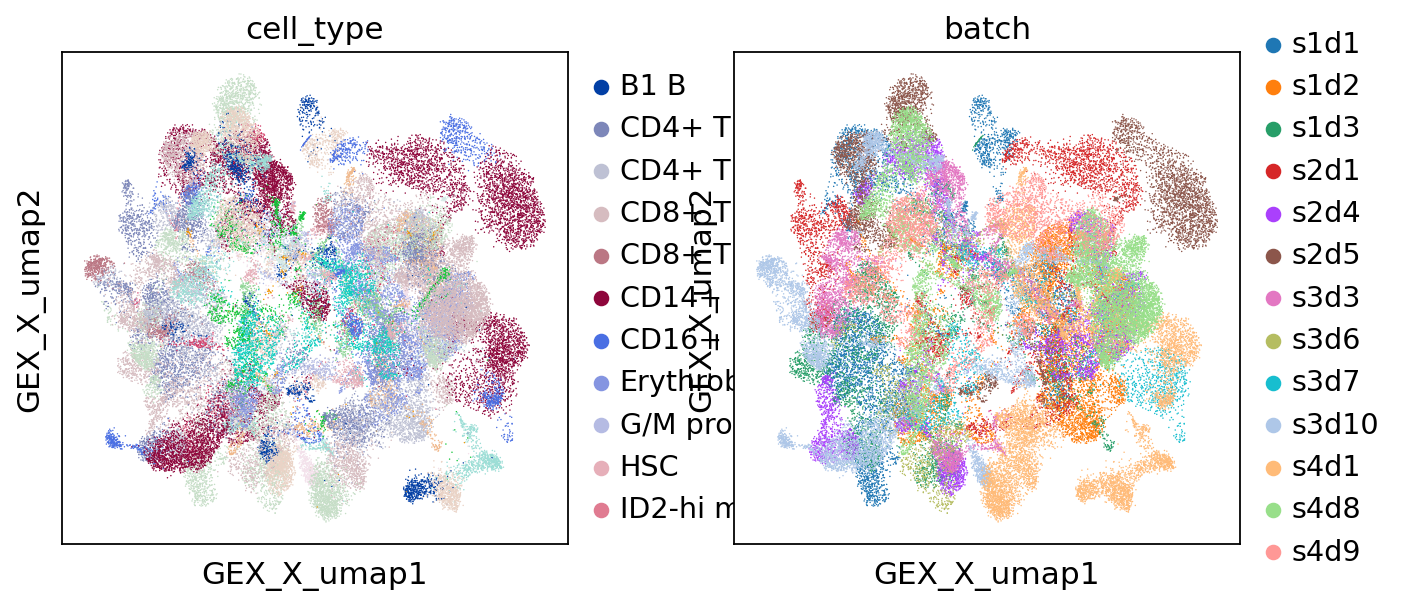

In [11]:
print('all data')
sc.pl.embedding(rna, 'GEX_X_umap', color=['cell_type','batch'])

custom batch (input


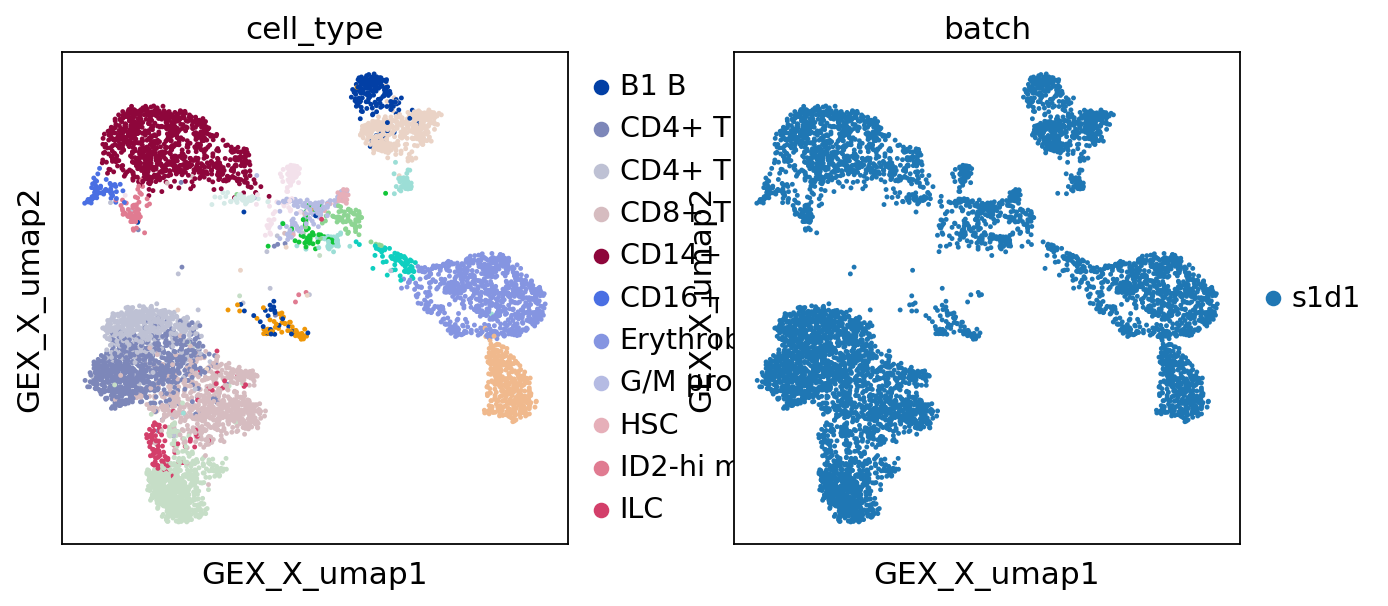

In [12]:
adata_batch = rna[rna.obs.batch == 's1d1',:] 
print('custom batch (input')
sc.pl.embedding(adata_batch, 'GEX_X_umap', color=['cell_type','batch'])

### To execute SCENIC, we define the input based on the dataset we have in place, and write the input file using loompy

In [19]:
# !wget https://raw.githubusercontent.com/aertslab/SCENICprotocol/master/example/allTFs_hg38.txt
tfs_path = 'allTFs_hg38.txt' 

In [20]:
loom_path = 'data/neurips_processed_input.loom'
loom_path_output = 'data/neurips_processed_output.loom'

tfs = [tf.strip() for tf in open(tfs_path)]
len(tfs)
# adata.var.index
# set(adata.var.index).intersection(set(tfs))
print(os.path.exists(loom_path), os.path.exists(loom_path_output))

True True


### Step recommendation: Check that most of your TFs are part of the provided object

In [15]:
# as a general QC. We inspect that our object has transcription factors listed in our main annotations.
print(np.sum(adata_batch.var.index.isin(tfs)), 'out of', len(tfs), 'TFs are found in the object')

1160 out of 1797 TFs are found in the object


In [32]:
use_hvg = True
if use_hvg:
    mask = (adata_batch.var['highly_variable'] == True) | adata_batch.var.index.isin(tfs)
    adata_batch = adata_batch[:,mask]

### Create a loom file for NeurIPS donor
- Note: the labels for Gene/CellID/etc. cannot be arbitrarily redefined, as then

In [41]:
row_attributes = { 
    "Gene": np.array(adata_batch.var.index) ,
}
col_attributes = { 
    "CellID":  np.array(adata_batch.obs.index) ,
    "nGene": np.array( np.sum(adata_batch.X.transpose()>0 , axis=0)).flatten() ,
    "nUMI": np.array( np.sum(adata_batch.X.transpose() , axis=0)).flatten() ,
}

lp.create(loom_path, adata_batch.X.transpose(), row_attributes, col_attributes )

In [42]:
adata_batch.shape

(6224, 2785)

In [16]:
outpath_adj = 'adj.csv'

In [43]:
if not os.path.exists(outpath_adj):
    !pyscenic grn {loom_path} {tfs_path} -o $outpath_adj --num_workers 3

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2022-08-03 14:55:24,528 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-03 14:55:25,551 - pyscenic.cli.pyscenic - INFO - Inferring regulatory networks.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/extended-single-cell-best-practices/jupyter-book/mechanisms/dask-worker-space/worker-8rk6uerp', purging
distributed.diskutils - INFO - Found stale lock file and directory '/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/extended-single-cell-best-practices/jupyter-book/mechanisms/dask-worker-space/worker-8uq

The output of this analysis is a set of associations between genes, inferred by GRNBoost, and summarized by a directional weight between TFs and target genes.

### Explore the generate TF-target gene adjacency matrices

In [17]:
results_adjacencies = pd.read_csv("adj.csv", index_col=False, sep=',')
results_adjacencies.head()

,TF,target,importance
0,SOX6,HBA2,142.369384
1,HMGB2,UBE2S,142.218855
2,SOX6,SLC4A1,134.277302
3,PAX5,EBF1,128.591770
4,SOX6,HBA1,126.211075


(-10.0, 10.0)

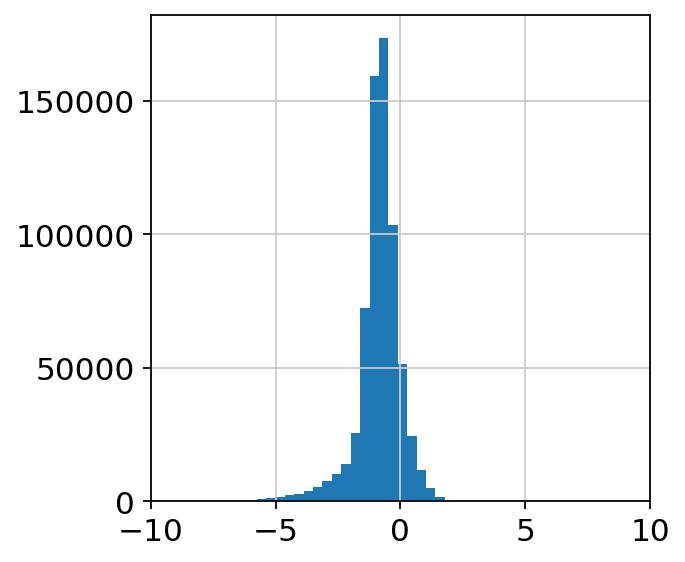

In [18]:
plt.hist(np.log10(results_adjacencies['importance']), bins=50)
plt.xlim([-10, 10])

### Targets genes have DNA motifs at promoters (sequence specific DNA motifs), those can be used to link TFs to target genes.

In [50]:
# !wget https://resources.aertslab.org/cistarget/databases/homo_sapiens/hg38/refseq_r80/mc9nr/gene_based/hg38__refseq-r80__10kb_up_and_down_tss.mc9nr.feather

In [6]:
import glob
# ranking databases
db_glob = "*feather"
db_names = ' '.join( glob.glob(db_glob) )



### Motif databases

- Here we use the archetypes definition of motifs, genome wide, to refine our associations between TFs and genes

In [52]:
# !wget https://resources.aertslab.org/cistarget/motif2tf/motifs-v9-nr.hgnc-m0.001-o0.0.tbl

In [9]:
import os

In [10]:
# motif databases
motif_path = "motifs-v9-nr.hgnc-m0.001-o0.0.tbl"
assert os.path.exists(motif_path)

This step can take ~8 minutes in a laptop.

In [1]:
!pyscenic ctx adj.csv \
    {db_names} \
    --annotations_fname {motif_path} \
    --expression_mtx_fname {loom_path} \
    --output reg.csv \
    --mask_dropouts \
    --num_workers 2 > pyscenic_ctx_stdout.txt

/bin/bash: pyscenic: command not found


Threshold for selection of best number of TFs
- Rule of thumb is to explore different thresholds visually, to obtain a high signal-to-noise ratio

custom quantiles for further exploration

In [13]:
import numpy as np
nGenesDetectedPerCell = np.sum(adata_batch.X>0, axis=1)
percentiles = pd.Series(nGenesDetectedPerCell.flatten().A.flatten()).quantile([.01, .05, .10, .50, 1])
print(percentiles)

0.01     369.23
0.05     488.00
0.10     634.00
0.50    1198.00
1.00    6245.00
dtype: float64


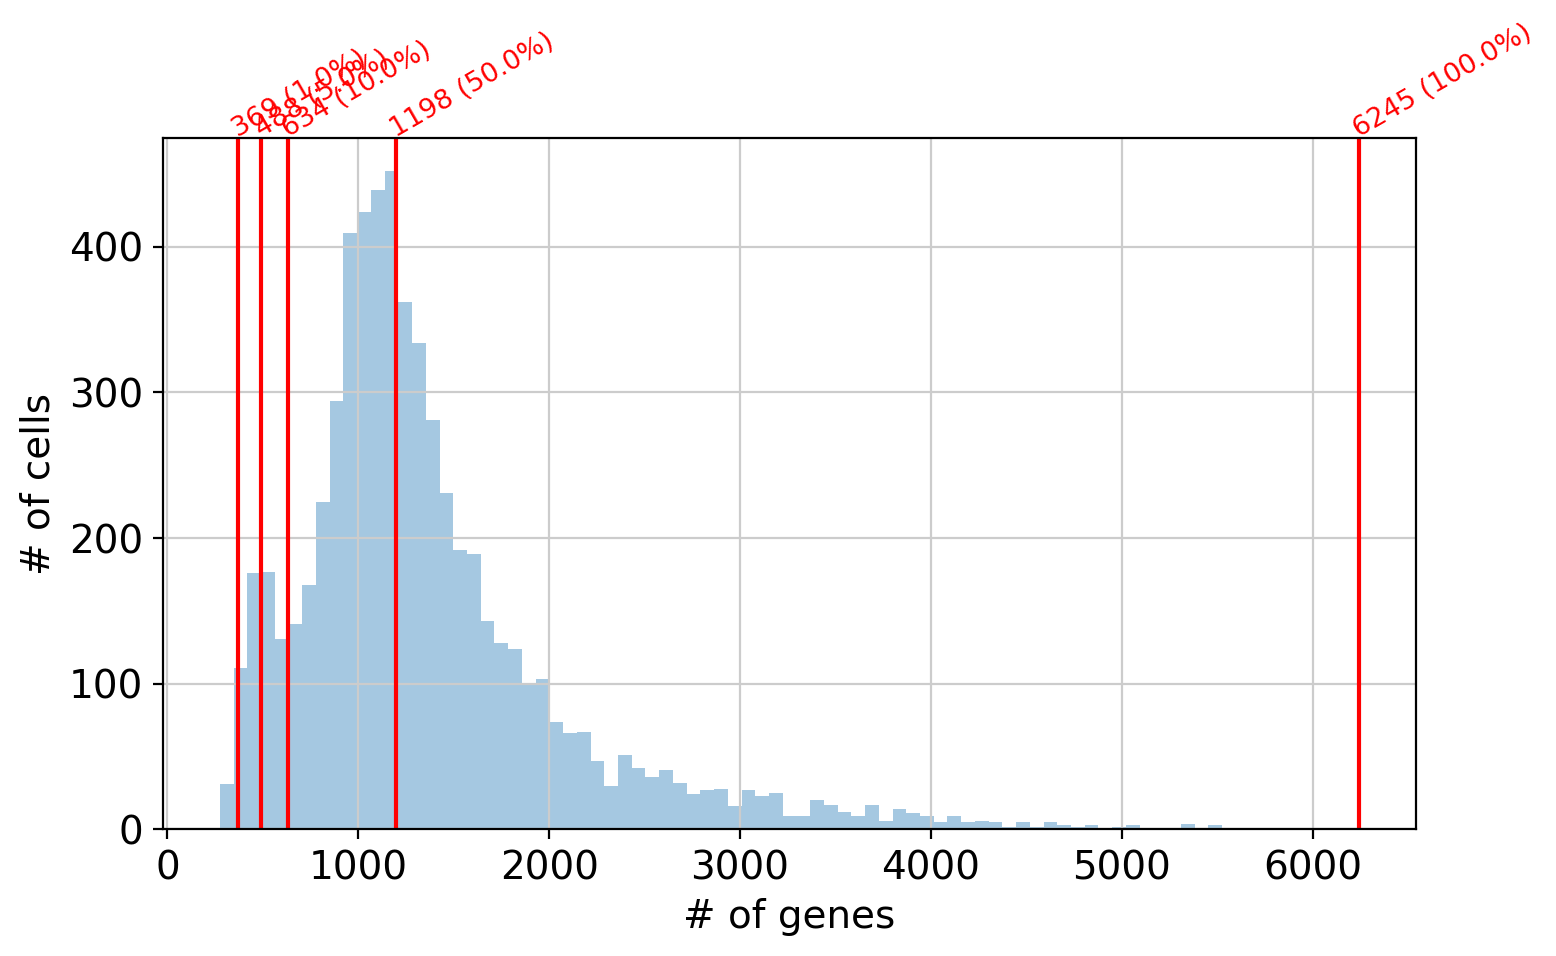

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5), dpi=100)
sns.distplot(nGenesDetectedPerCell, norm_hist=False, kde=False, bins='fd')
for i,x in enumerate(percentiles):
    fig.gca().axvline(x=x, ymin=0,ymax=1, color='red')
    ax.text(x=x, y=ax.get_ylim()[1], s=f'{int(x)} ({percentiles.index.values[i]*100}%)', color='red', rotation=30, size='x-small',rotation_mode='anchor' )
ax.set_xlabel('# of genes')
ax.set_ylabel('# of cells')
fig.tight_layout()

In [23]:
!pyscenic aucell $loom_path \
    reg.csv \
    --output {loom_path_output} \
    --num_workers 2 > pyscenic_aucell_stdout.txt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.

2022-08-03 21:35:02,926 - pyscenic.cli.pyscenic - INFO - Loading expression matrix.

2022-08-03 21:35:04,481 - pyscenic.cli.pyscenic - INFO - Loading gene signatures.
Create regulons from a dataframe of enriched features.
Additional columns saved: []

2022-08-03 21:35:06,588 - pyscenic.cli.pyscenic - INFO - Calculating cellular enrichment.

2022-08-03 21:35:15,990 - pyscenic.cli.pyscenic - INFO - Writing results to file.


In [21]:
import json
import zlib
import base64

# collect SCENIC AUCell output
lf = lp.connect( loom_path_output, mode='r+', validate=False )
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)
lf.close()

In [22]:
from MulticoreTSNE import MulticoreTSNE as TSNE

In [23]:
import umap

# UMAP
runUmap = umap.UMAP(n_neighbors=10, min_dist=0.4, metric='correlation').fit_transform
dr_umap = runUmap( auc_mtx )
pd.DataFrame(dr_umap, columns=['X', 'Y'], index=auc_mtx.index).to_csv( "scenic_umap.txt", sep='\t')


In [24]:
# tSNE
tsne = TSNE( n_jobs=20 )
dr_tsne = tsne.fit_transform( auc_mtx )


In [25]:
df_tsne = pd.DataFrame(dr_tsne, columns=['X', 'Y'], index=auc_mtx.index)
df_tsne.to_csv( "scenic_tsne.txt", sep='\t')

In [30]:
df_tsne.shape, adata_batch.shape

((6224, 2), (6224, 13431))

### Visualize the data base on the TF-regulons and auc_mtx generated.

In [35]:
sc.pp.neighbors(adata_batch)
sc.tl.umap(adata_batch)

         Falling back to preprocessing with `sc.pp.pca` and default params.


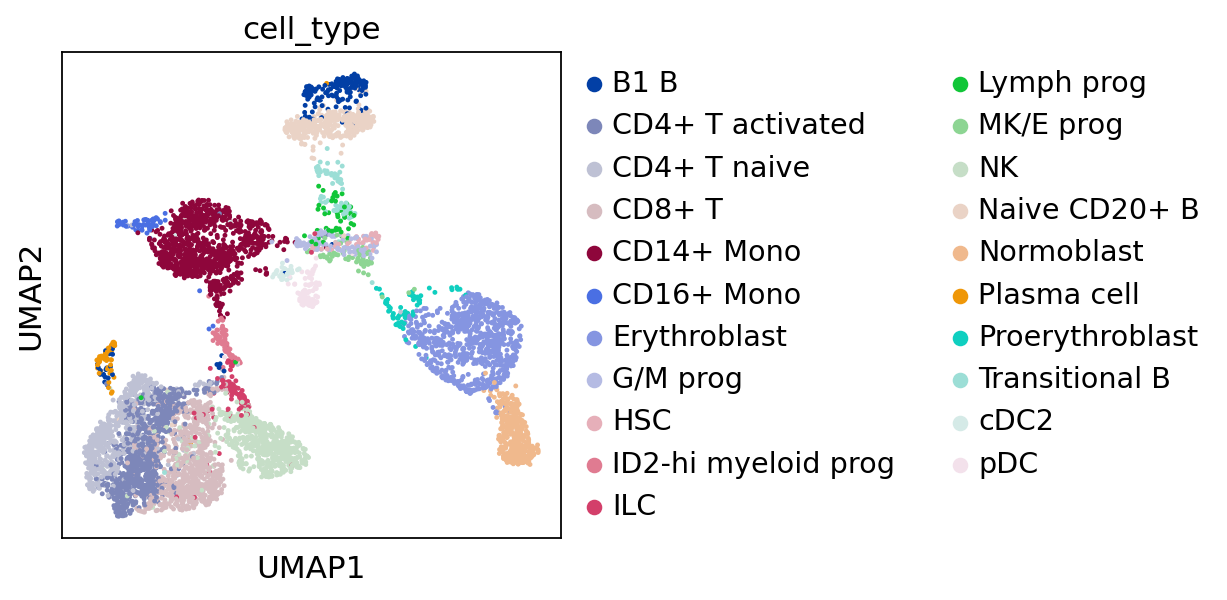

In [40]:
sc.pl.umap(adata_batch, color='cell_type')

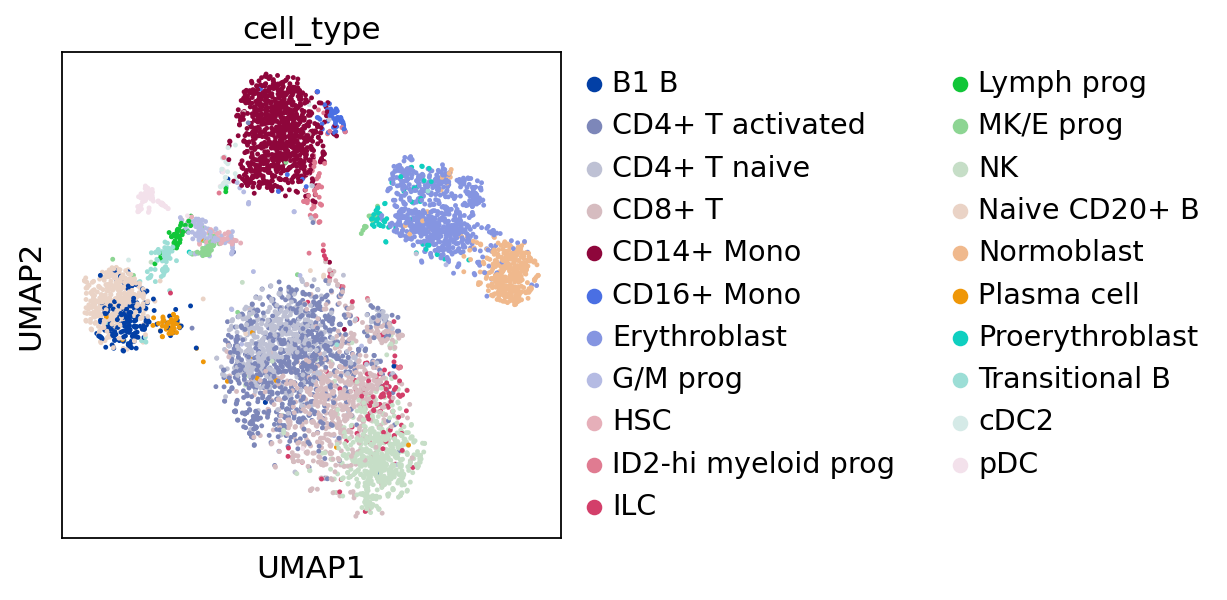

In [47]:
adata_batch.obsm['X_umap'] = df_tsne.to_numpy()
sc.pl.umap(adata_batch, color='cell_type')

### Pending: Inspection of recovered regulons.

**Interpretation statements**

### Preparation of R input for RNA+ATAC

### RNA (s1d1)

In [1]:
import scanpy as sc
import os
from matplotlib import rcParams
import pandas as pd
path_s1d1 = '../../data/openproblems_bmmc_multiome_genes_filtered_s1d1.h5ad'
if not os.path.exists(path_s1d1):
    adata = sc.read_h5ad('../../data/openproblems_bmmc_multiome_genes_filtered.h5ad')
    adata_s1d1 = adata[adata.obs.batch == 's1d1',:] 
    adata_s1d1.write(path_s1d1, compression='lzf')
    del adata

adata_s1d1 = sc.read_h5ad(path_s1d1)

/home/rio/miniconda3/envs/extended_best_practices_grn/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


custom batch (input


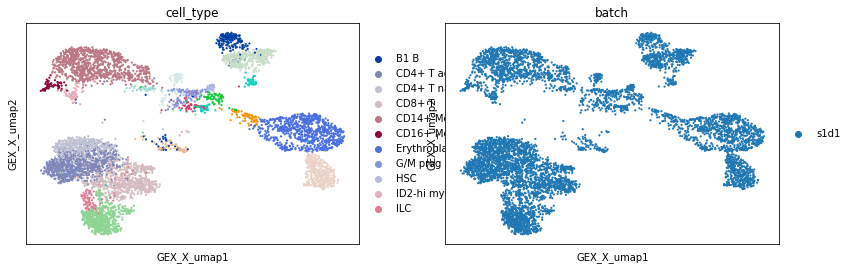

In [4]:
rna = adata_s1d1[:,adata_s1d1.var.feature_types == 'GEX']
sc.pp.log1p(rna)
rna.obs.batch.value_counts()

print('custom batch (input')
rcParams['figure.facecolor'] = 'white'

sc.pl.embedding(rna, 'GEX_X_umap', color=['cell_type','batch'])


In [5]:
# rna_dense = pd.DataFrame(data=rna.X.todense())
# rna.var.to_csv('../../data/openproblems_bmmc_multiome_genes_filtered_rna_s1d1_var.csv.gz', index=True, compression='gzip')
rna.to_df().to_csv('../../data/openproblems_bmmc_multiome_genes_filtered_rna_s1d1.csv.gz', compression='gzip')

### ATAC (s1d1)

custom batch (input


/home/rio/miniconda3/envs/extended_best_practices_grn/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value


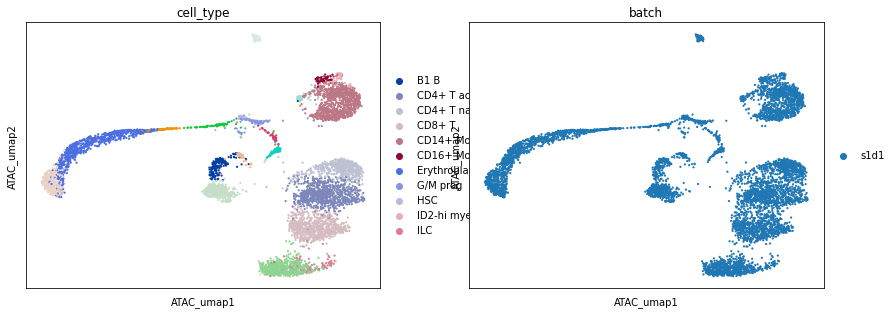

In [2]:
atac = adata_s1d1[:,adata_s1d1.var.feature_types == 'ATAC']
print('custom batch (input')
sc.pl.embedding(atac, 'ATAC_umap', color=['cell_type','batch'])

In [3]:
atac_obs = atac.obs

atac_obs['UMAP1'] = atac.obsm['ATAC_umap'][:,0]
atac_obs['UMAP2'] = atac.obsm['ATAC_umap'][:,1]
atac_obs.to_csv('../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_obs.csv.gz')


In [ ]:
atac_df = atac.to_df().T
atac_df['chr'] = atac_df.index.str.split('-').str[0]
atac_df['start'] = atac_df.index.str.split('-').str[1]
atac_df['end'] = atac_df.index.str.split('-').str[1]

# locate at the beginning of the dataframe
for i, c in enumerate(['chr', 'start', 'end']):
    print(i, c)
    column_to_move = atac_df.pop(c)
    atac_df.insert(i, c, column_to_move)
    
atac_bkp_path = '../../data/openproblems_bmmc_multiome_genes_filtered_atac_s1d1_counts_transposed.csv.gz'
atac_df = atac_df.T


0 chr
1 start
2 end


In [ ]:
atac_df.shape

In [ ]:

if not os.path.exists(atac_bkp_path):
    atac_df.T.to_csv(atac_bkp_path, compression='gzip')

0 chr
1 start
2 end


In [45]:
### Prepare peak-rna correlation
### (deprecated. Done in R now.)

#### calculating the correlations between rna and atac (slow, but only done once) 
# rna_df = rna.to_df()
# atac_df = atac.to_df()
# rna_df.shape, atac_df.shape
# cis_corr = []
# for gi, g in enumerate(rna_df.columns):
#     if gi % 250 == 0:
#         print(gi, g, 'out of', len(rna_df.columns))
#     gex = rna_df[g]
#     for p in atac_df.columns:
#         acc = atac_df[p]
#         corr, pval = pearsonr(gex, acc)        
#         # print(g, p, corr, pval)
#         cis_corr.append([p, p, g, corr, pval])
#         # assert False
    

### Notes on SCENIC:

The SCENIC pipelines requires RNA expression and TF-regulon information as input. Requires labels for categories. We recommend global and cluster specific differences, in order to tease out patterns associated to specific biological groups.

## Key Takeaways

1. Experimental design and analysis
2. Detect global and cluster-specific regulons allows going into types of signal based on how easy and those are to be assessed as significant.
3. Statistical power is increased by generating broad gene groups with at least 100 or more genes per category. Lower gene numbers per group would dissipate the signal, and make the listing of TF-gene associations per cluster more difficult.

## Quiz

1. What is a TF-regulon and in what scenarios it might be worth discovering those?
2. What is the futility theorem? 
3. Are there more motif categories or more transcription factors? How can one reconcile the redundancy of these during the analysis?
4. How can one find cluster specific TF-regulons?


## References